In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import os
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
sns.set_context("notebook")
from scipy.stats import norm
from bokeh.plotting import figure, show
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.stats import norm

DATA_DIR = 'data'

In [2]:
# taken from https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py
"""
=========================================
Plot Hierarachical Clustering Dendrogram 
=========================================
This example plots the corresponding dendrogram of a hierarchical clustering
using AgglomerativeClustering and the dendrogram method available in scipy.
"""

import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [3]:
def add_CI_to_DF(df, mean_col_name="avg_tone", std_col_name="std_tone", count_col_name="count_mentions", alpha=0.05):
    """
    by the Continuous limit theorem, the mean of a R.V. is distributed as N(\mu, \sigma^2/n)
    We will compute the bounds and add them to the dataframe assuming the CLT holds even tough 
    n is finite
    
    :param df: the dataframe
    :param mean_col_name: the name of the column of df containing the mean of the data
    :param std_col_name: the name of the column of df containing the std of the data
    :param count_col_name: the name of the column of df containing the count of the data
    """
    if df[count_col_name].min() < 10000:  # the factor 10000 is arbitrary, obviously there is
        # no guarantee that CI for rows with > 10000 mentions will be great
        print(f"The df has rows with a size that is small w.r.t. the validity of our approximation ({df[count_col_name].min()})")

    interval = norm.interval(1-alpha)
    mean_std = df[std_col_name] / (df[count_col_name]**0.5)
    df[mean_col_name + "_low_CI"] = interval[0]*mean_std + df[mean_col_name]
    df[mean_col_name + "_high_CI"] = interval[1]*mean_std + df[mean_col_name]

In [4]:
country_to_country_view = pd.read_csv(os.path.join(DATA_DIR, 'country_to_country_view.csv')).dropna()  # 3 rows have no mention_country
country_inner_view = pd.read_csv(os.path.join(DATA_DIR, 'country_inner_view.csv'))
country_outer_view = pd.read_csv(os.path.join(DATA_DIR, 'country_outer_view.csv'))
country_inner_type_view = pd.read_csv(os.path.join(DATA_DIR, 'country_inner_type_view.csv'))
country_outer_type_view = pd.read_csv(os.path.join(DATA_DIR, 'country_outer_type_view.csv'))
country_to_type_view = pd.read_csv(os.path.join(DATA_DIR, 'country_to_country_type_view.csv'))
media_to_country_view = pd.read_csv(os.path.join(DATA_DIR, 'media_to_country_view.csv.zip'))

#### scatterplot inner-outer view by type

In [5]:
country_to_type_view[country_to_type_view.actor_country == "United States"].groupby("actor_type").count_mentions.sum().sort_values()

actor_type
INS           2
SEP         355
SET         613
RAD         731
IGO        1245
ENV        6762
REF       11372
SPY       28545
REB       38953
UAF       41793
CRM       63709
HRI       64100
LAB       70858
AGR       81086
OPP      108086
HLH      215058
NGO      271446
MIL      428533
BUS      502326
ELI      756253
CVL      866202
LEG     1163683
EDU     1453881
COP     2021742
JUD     2131908
MNC     2659906
MED     5964871
GOV    12266522
Name: count_mentions, dtype: int64

In [6]:
selected_type = "GOV"
c_to_t_selected_type = country_to_type_view[country_to_type_view.actor_type == selected_type]
select_out = c_to_t_selected_type.apply(lambda x: x.actor_country != x.mention_country, axis=1)
outer_view_type = c_to_t_selected_type[select_out].copy()
outer_view_type["sum_mentions"] = outer_view_type.groupby("actor_country").count_mentions.transform("sum")
outer_view_type = outer_view_type.groupby("actor_country").apply(lambda x: x.avg_tone * x.count_mentions \
                                        / x.sum_mentions).groupby("actor_country").sum()

inner_view_type = c_to_t_selected_type[np.logical_not(select_out)]

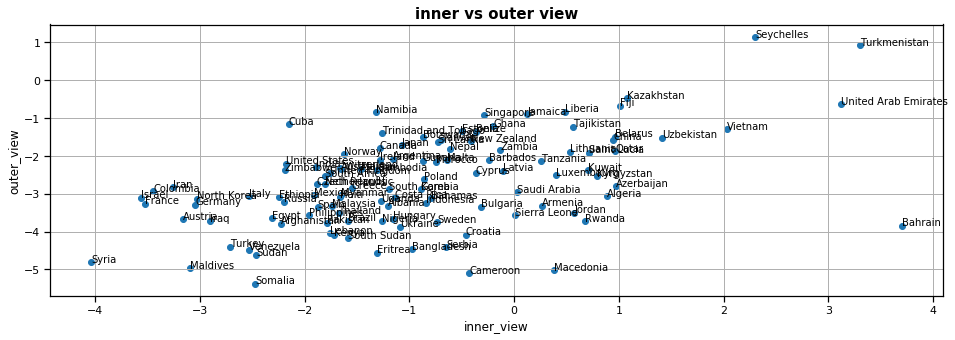

In [7]:
inner_view_type_rel = inner_view_type[inner_view_type["count_events"] > 1000]
outer_view_type_rel = pd.DataFrame(outer_view_type, columns=["avg_tone"])
inner_outer_view = inner_view_type_rel[["actor_country", "avg_tone"]].merge(outer_view_type_rel, left_on="actor_country", 
                                            right_index=True, suffixes=("_in", "_out"))
inner_outer_view.reset_index(inplace=True)
fig, ax = plt.subplots(figsize=(16,5))
ax.scatter(x='avg_tone_in', y='avg_tone_out', data=inner_outer_view)
ax.set_title("inner vs outer view", fontsize=15, fontweight='bold')
ax.set_ylabel('outer_view')
ax.set_xlabel('inner_view')
ax.grid(True)

for i, txt in enumerate(inner_outer_view.actor_country):
    ax.annotate(txt, (inner_outer_view.avg_tone_in[i], inner_outer_view.avg_tone_out[i]))

#### clustering with or without actor_types

In [8]:
# taking the biggest countries in term of references
selected_type = "GOV"
big_countries = list(country_outer_view.sort_values(by="count_mentions", 
                                                    ascending=False).head(40).country)
# only uses mentions where actor_type is selected_type
#to_cluster = country_to_type_view[country_to_type_view.apply(lambda x: x.actor_country in big_countries 
#            and x.mention_country in big_countries and x.actor_type == selected_type , axis = 1)].copy()

# all actor types
to_cluster = country_to_country_view[country_to_country_view.apply(lambda x: x.actor_country in big_countries 
                                         and x.mention_country in big_countries, axis = 1)].copy()

# proportion of time a mention from mention_country is about actorcountry
to_cluster["prop_mentions"] = to_cluster["count_mentions"] / to_cluster.groupby("mention_country").count_mentions.transform("sum")

to_cluster = to_cluster[["actor_country", "mention_country", "avg_tone", "prop_mentions"]]
countries = np.intersect1d(to_cluster.actor_country.unique(), to_cluster.mention_country.unique())
to_cluster = to_cluster.set_index(["actor_country", "mention_country"])  # so that access is fast

In [9]:
opinions = np.zeros((countries.shape[0], countries.shape[0]))  # if there are no mentions about
# that country, the count should be of 0
for i in range(opinions.shape[0]):
    for j in range(opinions.shape[0]):
        try:
            #if countries[i] in ["United States"]:
                elem = to_cluster.loc[countries[i], countries[j]]
                opinions[j,i] = elem["avg_tone"] #* elem["prop_mentions"] * 1000  # the 1000 is just
                # here to avoid having too small numbers for readability of the dataframes
                # opinions[j,i] because we categorize each country by the way he sees the other
                # ones
        except KeyError as e:
            pass  # in this case we leave the default value in the array since there is no mention

['Germany' 'Greece' 'Indonesia' 'Italy' 'Jordan' 'Mexico' 'Russia']
['China' 'South Korea' 'Vietnam']
['Australia' 'Canada' 'Egypt' 'France' 'Iran' 'Iraq' 'Ireland' 'Israel'
 'Japan' 'Lebanon' 'Malaysia' 'Nigeria' 'Pakistan' 'Philippines'
 'Saudi Arabia' 'Switzerland' 'Syria' 'Turkey' 'United Kingdom'
 'United States']
['West Bank']
['Yemen']
['Poland']
['Ukraine']
['Spain']
['Cuba']
['Afghanistan']
['North Korea']
['Netherlands']
['Belgium']


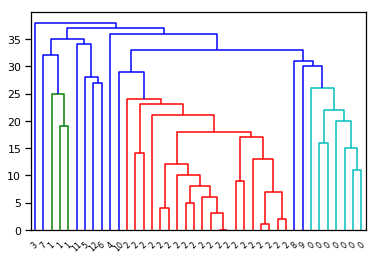

In [10]:
opinions = opinions[:, np.sum(opinions, 0) != 0]
model = AgglomerativeClustering(n_clusters=13, affinity="l1", linkage="average")
clusters = model.fit_predict(opinions)
plot_dendrogram(model, labels=model.labels_)

for i in range(np.max(clusters)+1):
    print(countries[clusters == i])

In [11]:
to_cluster.loc["United States", "United States"].avg_tone

-2.6408994942232433

In [12]:
from pprint import pprint
pprint(opinions.tolist())

[[-3.8988008497777615,
  -2.1337765028716977,
  -1.631433341713424,
  -1.433787160839057,
  -0.7736641962117367,
  -2.5554498757794715,
  -3.2514869624482303,
  -3.812281094918188,
  -3.8476927032769623,
  -5.215338407729629,
  0.5588045559396635,
  -2.747907014086908,
  -4.183810724441902,
  -2.6457826987020017,
  -2.861915076470249,
  -2.5854473324836453,
  -0.015721211707280896,
  -1.6270809024346466,
  -3.0701096034736164,
  -2.8447010901986896,
  -2.6414267819096118,
  -3.1805460657417566,
  -6.383826424113862,
  -3.8750556519856763,
  -3.495223933718876,
  -3.3021129214142397,
  -0.5461122466255853,
  -2.652980726859481,
  -2.2161754404066367,
  -2.172300480772356,
  -3.7431968570328937,
  -1.119181230812657,
  -4.344014465814978,
  -2.6479354051703776,
  -2.889394903859938,
  -2.393161594807883,
  -2.703297150555125,
  -3.350336831967596,
  -3.5556892780699627,
  -4.760496236473679],
 [-4.209037356246219,
  -1.8368022388181249,
  -4.52930296743078,
  -1.6392751833706596,
  -1.70

  -3.6687830679698377,
  -3.0323798464167697,
  -4.427954308108331,
  -3.0198856220820534,
  -4.1527032062568985,
  -3.0098055131112917,
  -2.825160225614717,
  -1.4830326370135316,
  -4.352093384422135,
  -4.242048796935612],
 [-2.7081509464251985,
  -1.238487707986898,
  -1.0523765659159159,
  0.9451876780711492,
  -0.09086913847887752,
  -1.4911523684227403,
  -1.8530715616978908,
  -1.6175857768543738,
  -1.4675368426864923,
  -0.907057245675831,
  0.5731271140926664,
  -1.1019986806605708,
  -3.0707835802861805,
  -0.05506083574156589,
  -0.0333417083955305,
  -1.5968454465751505,
  0.3084004446747682,
  -2.4822718219229762,
  -4.03633240785706,
  -2.999977882219337,
  0.3619552066416056,
  -1.6068289441380967,
  -2.110536977725558,
  -2.7145700131241086,
  -0.8836443583531861,
  -1.399065636772476,
  -0.5965616990092939,
  -3.2217910046287948,
  -1.4672380115861223,
  -0.6716707308775307,
  -2.2436626593532685,
  -1.3371797432676331,
  -3.744913490965316,
  -0.8611819093132481,
 

In [13]:
opinions.shape

(40, 40)

#### use the different types of actors of a country to compute several ranks and compare these between countries with confidence intervals.

In [14]:
big_countries_outer_view = country_outer_view[country_outer_view.apply(lambda x:
            x.country in big_countries and x.count_mentions > 10000, axis=1)].copy()
add_CI_to_DF(big_countries_outer_view)

big_countries_inner_view = country_inner_view[country_inner_view.apply(lambda x:
            x.country in big_countries and x.count_mentions > 10000, axis=1)].copy()
add_CI_to_DF(country_inner_view)


actor_types = ["COP", "EDU", "GOV", "JUD", "LEG", "MED", "MNC", "MIL"]

big_countries_outer_type_view = country_outer_type_view[country_outer_type_view.apply(lambda x:
 x.country in big_countries and x.actor_type in actor_types and x.count_mentions > 10000, axis=1)].copy()
add_CI_to_DF(big_countries_outer_type_view)

big_countries_inner_type_view = country_inner_type_view[country_inner_type_view.apply(lambda x:
 x.country in big_countries and x.actor_type in actor_types and x.count_mentions > 10000, axis=1)].copy()
add_CI_to_DF(big_countries_inner_type_view)

The df has rows with a size that is small w.r.t. the validity of our approximation (1)


In [15]:
big_countries_outer_view[["country", "avg_tone", "avg_tone_low_CI", "avg_tone_high_CI"]].sort_values("avg_tone", ascending=False)

,country,avg_tone,avg_tone_low_CI,avg_tone_high_CI
158,Cuba,-1.204931,-1.209361,-1.200500
31,Japan,-1.548538,-1.551761,-1.545316
121,Ireland,-1.625583,-1.631972,-1.619194
125,Canada,-1.655987,-1.659991,-1.651984
82,China,-1.769359,-1.771445,-1.767273
169,Vietnam,-1.818816,-1.824762,-1.812870
161,Australia,-2.144507,-2.148752,-2.140262
143,United Kingdom,-2.228129,-2.230527,-2.225731
23,Switzerland,-2.292864,-2.299263,-2.286465
84,United States,-2.309722,-2.311403,-2.308040


In [16]:
big_countries_inner_type_view[big_countries_inner_type_view.actor_type == "COP"]\
[["country", "avg_tone", "avg_tone_low_CI", "avg_tone_high_CI"]].sort_values(
    "avg_tone", ascending=False)

,country,avg_tone,avg_tone_low_CI,avg_tone_high_CI
544,United Kingdom,-4.188163,-4.207567,-4.168759
154,Malaysia,-4.230542,-4.283715,-4.177368
2397,Australia,-4.414687,-4.433007,-4.396366
871,Philippines,-4.576811,-4.607466,-4.546155
1080,Nigeria,-4.812751,-4.856775,-4.768728
395,Canada,-5.318536,-5.348311,-5.288762
740,United States,-5.921330,-5.926058,-5.916602
2902,Pakistan,-6.283409,-6.350060,-6.216758
2330,Israel,-7.704715,-7.732209,-7.677221


#### Inner media variance
We will sort sources of each country by importance (growing number of news) and group progressively the consecutive sources to form groups that have the same count of mentions but that contains new of very different sizes.

In [17]:
def get_source_importance(ser, nbr_clutsers):
    """
    given a serie containing the news sources of a country sorted by number of mentions and
    their number of mentions,
    return a label(0 to nbr_clutsers-1) for each of these sources so that each label contains
    as much mentions and that a smaller label contains smaller sources
    """
    cumsum = ser.cumsum()
    total_nbr_mentions = cumsum.tail(1)
    offsets = np.array([i * total_nbr_mentions/nbr_clutsers for i in range(nbr_clutsers)]).flatten()
    # lower bound for each cluster
    return cumsum.apply(lambda x: np.searchsorted(offsets, x) - 1) # offset in list

In [19]:
source_cluster = media_to_country_view.groupby(["source_country",
                                            "source_name"]).agg({"count_mentions": "sum"})
source_cluster = source_cluster.sort_values(["source_country", "count_mentions"])
source_cluster["cluster"] = source_cluster.groupby("source_country").count_mentions.apply(
    lambda x: get_source_importance(x, 2))
source_cluster = source_cluster.reset_index()[["source_name", "cluster"]]

news_to_country = media_to_country_view.merge(source_cluster, left_on="source_name",
                                        right_on="source_name", suffixes=('',''))
news_to_country = news_to_country.groupby(["actor_country", "source_country", 
            "cluster"]).agg({"avg_tone": "mean", "count_mentions": "sum"})

In [20]:
news_to_country

avg_tone  count_mentions
actor_country source_country       cluster                          
Afghanistan   Afghanistan          0       -2.421902          111567
                                   1       -3.571215           83650
              Albania              0       -3.872089              10
                                   1       -3.586401             141
              Algeria              0       -8.188755               7
                                   1       -4.026846               2
              Angola               1       -6.081544             119
              Argentina            0       -1.549782              64
                                   1       -4.845821             268
              Armenia              0       -2.686694             773
                                   1       -5.200301            2103
              Australia            0       -2.438905           55843
                                   1       -4.234884           57951
              Austria              0        0.018183             109
                                   1       -5.501094             117
              Azerbaijan           0       -0.501354            3131
                                   1       -2.385947            3012
              Bahamas              0       -1.534083               2
                                   1       -4.886480               7
              Bahrain              0       -6.270824             495
                                   1       -7.431235            1035
              Bangladesh           0       -4.064385            7184
                                   1       -5.598902            8548
              Barbados             0       -8.069566              16
                                   1       -5.210517             137
              Belarus              0        0.980378              82
                                   1       -0.211938             155
              Belgium              0        0.158869              83
                                   1       -4.576165              90
              Belize               0       -3.212220               7
...                                              ...             ...
Zimbabwe      Thailand             0       -3.539694              99
                                   1       -3.998320             272
              Togo                 0        0.440529               8
              Trinidad and Tobago  0       -1.223808             135
                                   1       -1.893356              37
              Turkey               0       -4.621429             396
                                   1       -3.285399            1182
              Tuvalu               0       -3.523693             558
                                   1       -4.865833             773
              Uganda               0       -1.531342             853
                                   1       -2.278486             670
              Ukraine              0       -1.819328               6
                                   1       -2.773010               5
              United Arab Emirates 0        0.131165             347
                                   1       -1.226618             145
              United Kingdom       0       -1.025339           37941
                                   1       -3.154988           17675
              United States        0       -2.503085          124644
                                   1       -3.694257          149780
              Vatican City         0        1.897791             101
                                   1        1.912079              93
              Venezuela            0       -1.319073              33
                                   1       -1.757717              28
              Vietnam              0       -4.540979              19
                                   1       -2.364986              64
              Virgin Islands       1      